In [168]:
import yaml
import pickle
import pandas as pd
import numpy as np
import lightgbm as lgb
import math


In [3]:
with open('..\params.yaml', 'r') as fd:
    params = yaml.safe_load(fd)

In [4]:
pickledir = params['prepare-step2']['pickle-dir']
with open(pickledir, 'rb') as fd:
    each_faction_dataset = pickle.load(fd)


In [5]:
feats = each_faction_dataset['auren']['features']

In [8]:
y_data = np.array(each_faction_dataset['auren']['vp'])

In [9]:
type(y_data)

numpy.ndarray

In [10]:
y_data.shape

(11610,)

In [137]:
faction = 'swarmlings'

In [138]:
Xdata = each_faction_dataset[faction]['features']
Xdata.drop(['Unnamed: 0', 'game'], axis=1)
traindata = lgb.Dataset(Xdata,
                        label=np.array(each_faction_dataset[faction]['vp']))

In [139]:
Xdata = each_faction_dataset[faction]['features']
Xdata = Xdata.drop(['Unnamed: 0', 'game'], axis=1)
Xdata.shape

(27967, 71)

In [140]:
Xdata.columns

Index(['r1_SCORE1', 'r1_SCORE2', 'r1_SCORE3', 'r1_SCORE4', 'r1_SCORE5',
       'r1_SCORE6', 'r1_SCORE7', 'r1_SCORE8', 'r1_SCORE9', 'r2_SCORE1',
       'r2_SCORE2', 'r2_SCORE3', 'r2_SCORE4', 'r2_SCORE5', 'r2_SCORE6',
       'r2_SCORE7', 'r2_SCORE8', 'r2_SCORE9', 'r3_SCORE1', 'r3_SCORE2',
       'r3_SCORE3', 'r3_SCORE4', 'r3_SCORE5', 'r3_SCORE6', 'r3_SCORE7',
       'r3_SCORE8', 'r3_SCORE9', 'r4_SCORE1', 'r4_SCORE2', 'r4_SCORE3',
       'r4_SCORE4', 'r4_SCORE5', 'r4_SCORE6', 'r4_SCORE7', 'r4_SCORE8',
       'r4_SCORE9', 'r5_SCORE1', 'r5_SCORE2', 'r5_SCORE3', 'r5_SCORE4',
       'r5_SCORE5', 'r5_SCORE6', 'r5_SCORE7', 'r5_SCORE8', 'r5_SCORE9',
       'r6_SCORE1', 'r6_SCORE2', 'r6_SCORE3', 'r6_SCORE4', 'r6_SCORE5',
       'r6_SCORE6', 'r6_SCORE7', 'r6_SCORE8', 'r6_SCORE9', 'BON1', 'BON2',
       'BON3', 'BON4', 'BON5', 'BON6', 'BON7', 'BON8', 'BON9', 'BON10',
       '2players', '3players', '4players', '5players', 'map1', 'map2', 'map3'],
      dtype='object')

In [141]:
traindata = lgb.Dataset(Xdata,
                        label=np.array(each_faction_dataset[faction]['vp']))

In [142]:
len(np.array(each_faction_dataset[faction]['vp']))

27967

In [143]:
num_round=500
param = {'num_leaves': 300, 'objective': 'regression'}
bst = lgb.train(param, traindata, num_round)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 27967, number of used features: 69
[LightGBM] [Info] Start training from score 101.014803


In [144]:
testdata = Xdata.iloc[:, :]
testdata.shape

(27967, 71)

In [145]:
ypred = bst.predict(Xdata)

In [146]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [147]:
MAE = metrics.mean_absolute_error(ypred, np.array(each_faction_dataset[faction]['vp']))
MAE

5.046741950738864

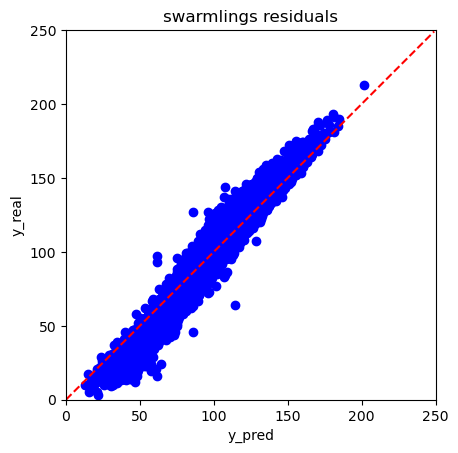

In [148]:
line = list(range(250))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')
ax.set_title(f'{faction} residuals')
plt.plot(ypred, np.array(each_faction_dataset[faction]['vp']), 'bo', line, line, 'r--')
plt.xlabel('y_pred')
plt.ylabel('y_real')
plt.xlim([0, 250])
plt.ylim([0, 250])
plt.show()

In [169]:
residuals = np.array(ypred) - np.array(each_faction_dataset[faction]['vp'])
avgres = np.mean(residuals)
original = np.array(each_faction_dataset[faction]['vp']) - np.mean(np.array(each_faction_dataset[faction]['vp']))
maxorig = math.ceil(np.max(original))
minorig = math.floor(np.min(original))
bins_list = list(range(minorig, maxorig))

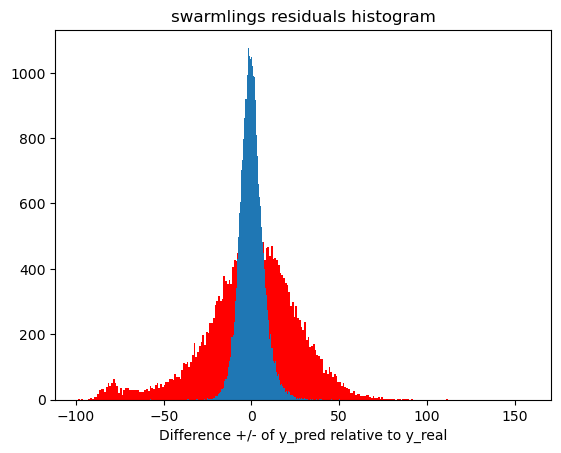

In [171]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(f'{faction} residuals histogram')
plt.hist(original, bins=bins_list, color='r')
plt.hist(residuals, bins=200)
plt.xlabel('Difference +/- of y_pred relative to y_real')
#h = ax.plot([avgres, avgres], [0, 600], 'r--')
plt.show()

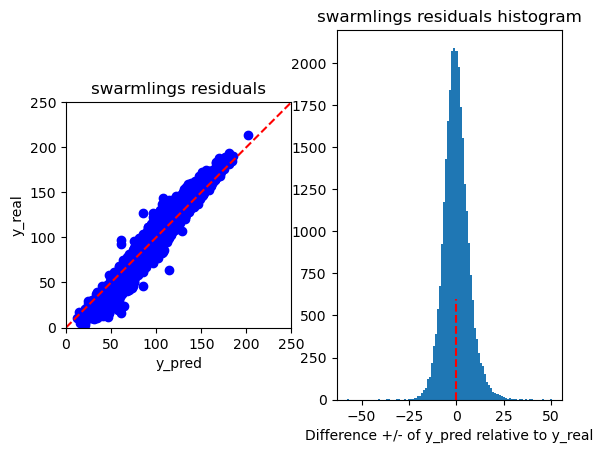

In [154]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_aspect('equal', adjustable='box')
ax1.set_title(f'{faction} residuals')
ax1.plot(ypred, np.array(each_faction_dataset[faction]['vp']), 'bo', line, line, 'r--')
ax1.set(xlabel='y_pred', ylabel='y_real')
ax1.set(xlim=[0, 250], ylim=[0, 250])

ax2.set_title(f'{faction} residuals histogram')
ax2.hist(residuals, bins=100)
ax2.set(xlabel='Difference +/- of y_pred relative to y_real')
h = ax2.plot([avgres, avgres], [0, 600], 'r--')
plt.show()

In [155]:
metricsdir = 'data/faction-picker-bot/metrics/'
plt.savefig(metricsdir + f'{faction} charts.png')